In [31]:
%run pipeline.py
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#plt.rcParams['ytick.left'] = True
#plt.rcParams['ytick.right'] = True
#plt.rcParams['xtick.top'] = True
#plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.minor.visible'] = True

# Sample

### BOSS target selection : 
$2.15<z<3.5$;
$ g<22 (or ~r<21.85)$ 

### Eftekharzadeh,Myers,et.al(2015):
BOSS:
$2.2<z<3.4;
NGC;
g<22;
-28.74<M_i<-23.78;
f_{comp}$>0.75

### Our selection:
QSO & DLA from DR12:
$2.2<z<3.4;
NGC;
g<22;
-28.74<M_i<-23.78;
non-FIRST$

DLA confidence > 0.3



In [1]:
# Data preparation, SGC+NGC

import pandas as pden
from astropy.io import fits
import numpy as np

DLA = pd.read_csv('../../data/matched_updated_dla.csv')  # updated dla catalogue 
DR12 = fits.open('../../data/DR12Q.fits')
q_mag = []
for i in DLA['PSFMAG']:
    q_mag.append(float(i.split(',')[1]))
q_mag = np.array(q_mag)    
q = DLA[(q_mag<=22)&(q_mag>=5.0)
                   &(DLA['MI']<-23.78)&(DLA['MI']>-28.74)
                   &(DLA['FIRST_MATCHED']==0.)
                   &(DLA['Z_VI']<=3.4)&(DLA['Z_VI']>=2.2)
                   &(DLA['conf']>0.3)
                   &(DLA['zabs']<DLA['Z_VI'])]
q_mag = []
for i in q['PSFMAG']:
    q_mag.append(float(i.split(',')[1]))
q_mag = np.array(q_mag) 

q_dla = pd.DataFrame(np.array([q['RA_2'],q['DEC_2'],q['Z_VI'],q['zabs'],q_mag,q['MI']]).T,columns=('ra','dec','z','z_dla','MAG','MI'))


q_dr12 = DR12[1].data[(DR12[1].data['PSFMAG'][:,1]<=22)& (DR12[1].data['PSFMAG'][:,1]>=5.)
                            &(DR12[1].data['MI']<-23.78)&(DR12[1].data['MI']>=-28.74)
                            &(DR12[1].data['Z_VI']<=3.4)&(DR12[1].data['Z_VI']>=2.2)
                            &(DR12[1].data['FIRST_MATCHED']==0)
                            &(DR12[1].data['BOSS_TARGET1']!=0)]
q_dr12 = pd.DataFrame(np.array([q_dr12['RA'],q_dr12['DEC'],q_dr12['Z_VI'],q_dr12['PSFMAG'][:,1],q_dr12['MI']]).T,columns=('ra','dec','z','MAG','MI'))



In [33]:
'''
exclude SGC and plot maps
'''

from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp

n = SkyCoord(ra=q_dla['ra'],dec=q_dla['dec'],unit='deg',frame='icrs')
ng = n.galactic
l,b = ng.l,ng.b
q_dla = q_dla[b>0]

q = np.unique(np.array([q_dla['ra'],q_dla['dec'],q_dla['z'],q_dla['MI'],q_dla['MAG']]).T,axis=0)
q = pd.DataFrame(q,columns=('ra','dec','z','MI','MAG'))

g = SkyCoord(ra=q['ra'],dec=q['dec'],unit='deg',frame='icrs')
gg = g.galactic
l = gg.l.degree
b = gg.b.degree


q_indice = hp.pixelfunc.ang2pix(32,l,b,lonlat=True)     
q_map = np.zeros(hp.nside2npix(32), dtype=np.float)      
for i in range(len(q_indice)):                             
    q_map[q_indice[i]] += 1
#hp.mollview(q_map,title='QSOs with DLAs:%d in total'%len(q),coord=['G'])



n = SkyCoord(ra=q_dr12['ra'],dec=q_dr12['dec'],unit='deg',frame='icrs')
ng = n.galactic
l,b = ng.l,ng.b
q_dr12 = q_dr12[b>0]

g = SkyCoord(ra=q_dr12['ra'],dec=q_dr12['dec'],unit='deg',frame='icrs')
gg = g.galactic
l = gg.l.degree
b = gg.b.degree

q_indice = hp.pixelfunc.ang2pix(32,l,b,lonlat=True)     
q_map = np.zeros(hp.nside2npix(32), dtype=np.float)      
for i in range(len(q_indice)):                             
    q_map[q_indice[i]] += 1
#hp.mollview(q_map,title='DR12 QSOs: %d in total'%len(q_dr12),coord=['G'])

print('N_dla=%d'%len(q_dla))
print('N_q_dla=%d'%len(q))
print('N_q_dr12=%d'%(len(q_dr12)))

N_dla=20848
N_q_dla=17774
N_q_dr12=105624


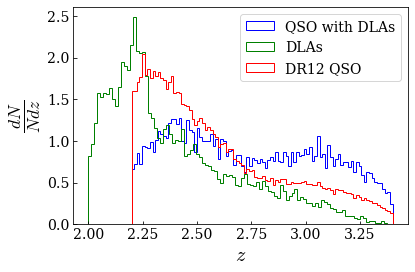

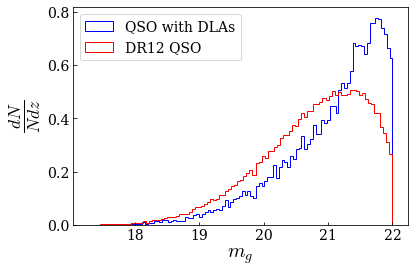

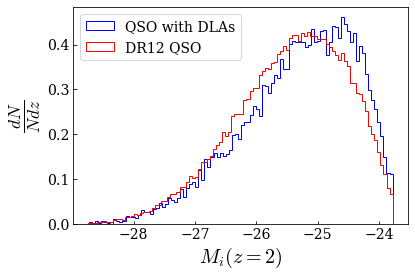

mean MI for QSO with DLAs is -25.322369
mean MI for DR12 QSO is -25.459159


In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(q['z'],100,histtype='step',density=True,color='blue',label='QSO with DLAs')
plt.hist(q_dla['z_dla'],100,histtype='step',density=True,color='green',label='DLAs')
plt.hist(q_dr12['z'],100,histtype='step',density=True,color='red',label='DR12 QSO')
#plt.title('Redshift distribution of QSO sample')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$\frac{dN}{Ndz}$',fontsize=25)
plt.legend(fontsize=14)
plt.savefig('Redshift distribution.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

plt.figure()
plt.hist(q['MAG'],100,histtype='step',density=True,color='blue',label='QSO with DLAs')
plt.hist(q_dr12['MAG'],100,histtype='step',density=True,color='red',label='DR12 QSO')
#plt.title('Magnitude distribution of QSO sample')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel(r'$m_g$',fontsize=20)
plt.ylabel(r'$\frac{dN}{Ndz}$',fontsize=25)
plt.savefig('Magnitude distribution.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

plt.figure()
plt.hist(q['MI'],100,histtype='step',density=True,color='blue',label='QSO with DLAs')
plt.hist(q_dr12['MI'],100,histtype='step',density=True,color='red',label='DR12 QSO')
#plt.title('Luminosity distribution of QSO sample')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel(r'$M_i(z=2)$',fontsize=20)
plt.ylabel(r'$\frac{dN}{Ndz}$',fontsize=25)
plt.savefig('Luminosity distribution.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

print('mean MI for QSO with DLAs is %f'%np.mean(q['MI']))
print('mean MI for DR12 QSO is %f'%np.mean(q_dr12['MI']))

# DR12

In [35]:
%run pipeline.py
cor = corr('../../data/Planck2018/MV/dat_klm.fits','../../data/Planck2018/mask.fits',q_dr12,nside=2048)
cor.cal_q_mask()
cor.cal_qso_overdensity_map()
cor.cal_kq_mask()
c_kq = cor.corr(lmax=1200)

bin_l,bin_cl = cor.bin_corr(c_kq,l_min=30,l_max=1200,band=15)
#err = cor.errorbar(c_kq,band=15,lmin=30,lmax=1200)
err = np.load('./matrix/std_q_10arcmin.npy')

s = np.log10(107551/105624)/0.1
print('s=%f'%s)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/littlelin/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
s=0.078518


In [36]:
%run pipeline.py
bia = bias(q_dr12['z'],2.2,3.4,s,[bin_l,bin_cl,err],z_reso=150)

a_opt,a_std = bia.opt_curvefit()
ckl = bia.theoretical_curve(a_opt,x=bia.data_l,line=False)
bia.outlier(ckl)

a_opt,a_std = bia.opt_curvefit()

Note: redshifts have been re-sorted (earliest first)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

/home/littlelin/anaconda3/lib/python3.7/site-packages/camb/results.py:946: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


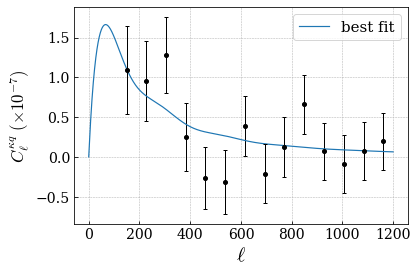

In [37]:
a = a_opt
l,cl = bia.theoretical_curve(a,x=range(1200),line=True)
plt.plot(l,cl*1E7,linewidth=1.2,label='best fit')
#l,cl = bia.theoretical_curve(1,x=range(1200),line=True)
#plt.plot(l,cl,'--',label='a=1')
#plt.errorbar(bia.outlier_l,bia.outlier_ckl*1E7,bia.outlier_err*1E7,c='red',fmt='o',linewidth=0.7,elinewidth=1,capsize=2,ms=4)
plt.errorbar(bia.data_l[:],bia.data_ckl[:]*1E7,bia.data_err[:]*1E7,fmt='o',c='k',linewidth=0.7,elinewidth=1,capsize=2,ms=4)
#plt.errorbar(bia.data_l[0],bia.data_ckl[0],bia.data_err[0],fmt='.',c='green',linewidth=0.7)
plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$C^{\kappa q}_{\ell} ~(\times 10^{-7})$',fontsize=17)
plt.grid(linestyle='--',linewidth=0.5)
plt.legend(fontsize=15)
plt.savefig('DR12_spectrum.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

In [38]:
z_eff = np.median(q_dr12['z'])  
print(z_eff)
halo = halomass(a_opt*bia.b_fid(z_eff),z_eff,[(a_std*bia.b_fid(z_eff))[0],(a_std*bia.b_fid(z_eff))[0]])
nu = halo.fsolve_nu()
halo.nu2mass()

2.506


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# DLA

In [39]:
%run pipeline.py
cor_dla = corr('../../data/Planck2018/MV/dat_klm.fits','../../data/Planck2018/mask.fits',q,nside=2048,q_mask=cor.q_mask)
#cor_dla.cal_q_mask()
cor_dla.cal_qso_overdensity_map()
cor_dla.cal_kq_mask()
c_kq_dla = cor_dla.corr(lmax=1200)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/littlelin/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [40]:
bin_l_dla,bin_cl_dla = cor_dla.bin_corr(c_kq_dla,l_min=30,l_max=1200,band=10)
#err_dla = cor_dla.errorbar(c_kq_dla,band=10,lmin=30,lmax=1200)
err_dla = np.load('./matrix/std_dla_10arcmin.npy')

In [41]:
s = np.log10(17882/17774)/0.01
print(s)

0.2630914712023014


### $b_{QSO+DLA}$

In [42]:
%run pipeline.py
bia = bias(q['z'],2.2,3.4,s,[bin_l_dla,bin_cl_dla,err_dla],z_reso=150)

Note: redshifts have been re-sorted (earliest first)


In [43]:
aa_opt,aa_std = bia.opt_curvefit()

ckl = bia.theoretical_curve(aa_opt,x=bia.data_l,line=False)
bia.outlier(ckl)

aa_opt,aa_std = bia.opt_curvefit()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### $b_{QSO} ~and~ b_{DLA}$
prior:  $b_{QSO}\sim N(b_q,\sigma_q^2)$ 

$$f(z)=\frac{b_{DLA}\frac{dN_{DLA}}{dz}}{\int \frac{ N_{DLA}}{dz}dz}+\frac{b_{QSO}\frac{dN_{QSO}}{dz}}{\int \frac{ N_{QSO}}{dz}dz}$$

In [44]:
%run pipeline.py
bia_dla = bias_dla(q['z'],q_dla['z_dla'],s,[bin_l_dla,bin_cl_dla,err_dla],z_reso=150)

Note: redshifts have been re-sorted (earliest first)


100%|██████████| 100000/100000 [12:33<00:00, 132.77it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

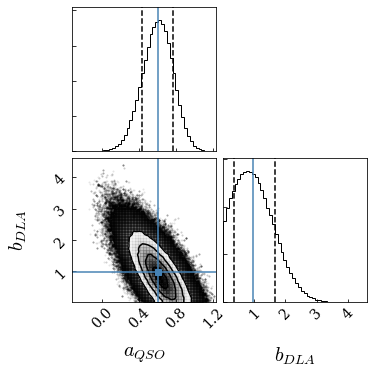

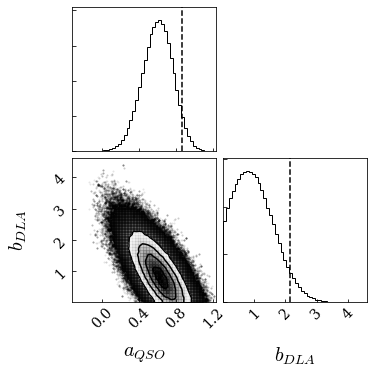

In [45]:
a_q, a_d, ad_std1, ad_std2,ad_95 = bia_dla.MCMC(distri_aq=[a_opt,a_std],discard=100,nstep=100000)
cl_dla = bia_dla.theoretical_curve(a_q,a_d,x=bia_dla.data_l,line=False)

In [46]:
#bia_dla.outlier(cl_dla)
#a_q, a_d, ad_std1, ad_std2,ad_95 = bia_dla.MCMC(distri_aq=[a_opt,a_std],discard=100,nstep=5000)

/home/littlelin/anaconda3/lib/python3.7/site-packages/camb/results.py:946: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


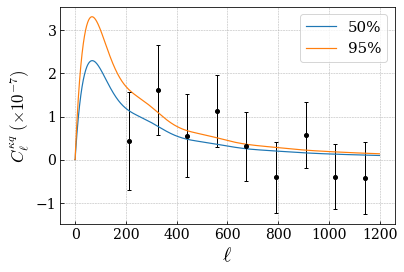

In [47]:
l,cl = bia_dla.theoretical_curve(a_q,a_d,x=range(1200),line=True)
l_95,cl_95 = bia_dla.theoretical_curve(a_q,ad_95,x=range(1200),line=True)
plt.plot(l,cl*1E7,'-',linewidth=1.2,label='50%')
plt.plot(l_95,cl_95*1E7,'-',linewidth=1.2,label='95%')
#plt.errorbar(bia_dla.outlier_l,bia_dla.outlier_ckl*1E7,bia_dla.outlier_err*1E7,c='red',fmt='o',linewidth=0.7,elinewidth=1,capsize=2,ms=4)
plt.errorbar(bia_dla.data_l[:],bia_dla.data_ckl[:]*1E7,bia_dla.data_err[:]*1E7,fmt='o',c='k',linewidth=0.7,elinewidth=1,capsize=2,ms=4)

#plt.errorbar(bia_dla.data_l[0],bia_dla.data_ckl[0],bia_dla.data_err[0],fmt='.',c='green',linewidth=1)
plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$C^{\kappa q}_{\ell} ~(\times 10^{-7})$',fontsize=17)
plt.grid(linestyle='--',linewidth=0.5)
plt.legend(fontsize=15)
plt.savefig('DLA_spectrum.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

### $M_{DLA}$ 

In [48]:
z_eff = np.median(q_dla['z_dla'])
print(z_eff)
halo = halomass(a_d,z_eff,[(ad_std1*bia_dla.b_fid(z_eff)),(ad_std2)])
nu = halo.fsolve_nu()
halo.nu2mass()

2.3035764951760145


/home/littlelin/anaconda3/lib/python3.7/site-packages/colossus/lss/bias.py:467: RuntimeWarning: invalid value encountered in power
  bias = 1.0 - A * nu**a / (nu**a + constants.DELTA_COLLAPSE**a) + B * nu**b + C * nu**c
/home/littlelin/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
z_eff = np.median(q_dla['z_dla'])
print(z_eff)
halo = halomass(ad_95,z_eff,[0,0])
nu = halo.fsolve_nu()
halo.nu2mass()

2.3035764951760145


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>